In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Load sequence trajectory data

def load_sequences(file_path, pick_every=1, split_on_tab=True, max_n_sequences=10) :
    seqs = []
    
    print("Processing '" + str(file_path) + "'...")
    
    try :
        with open(file_path, "rt") as f :
            i = 0
            for l in f.readlines() :
                l_strip = l.strip()
                seq = l_strip
                if split_on_tab :
                    seq = l_strip.split("\t")[0]

                if i % pick_every == 0 :
                    seqs.append(seq)
                
                i += 1
        
        if len(seqs) > max_n_sequences :
            seqs = seqs[:max_n_sequences]
        
        return seqs
    
    except FileNotFoundError :
        return []


In [3]:
#Create encoder
acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})


In [4]:
#Trajectory comparison configuration

traj_dirs = [
    "killoran",
    "fbvae/mpradragonn_fb_vae_epochs_50_kl_factor_05_iters_150_samples_1000_q_06",
    "cbas/mpradragonn_cbas_vae_epochs_50_kl_factor_05_iters_150_samples_1000_q_06_yt_scale_002_alpha_1_it_epochs_1",
    "cbas/mpradragonn_rwr_vae_epochs_50_kl_factor_05_iters_150_samples_1000_q_06_yt_scale_002_alpha_1_it_epochs_10",
    "../../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60",
    "../../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_80",
    "../seqprop_samples/seqprop_mpdradragonn_max_activity_20000_updates_non_normalized",
    "../seqprop_samples/seqprop_mpdradragonn_max_activity_20000_updates",
    "../seqprop_samples/seqprop_mpdradragonn_max_activity_20000_updates_elbo"
]

traj_file_funcs = [
    lambda i: "killoran_vae_epochs_50_kl_factor_05_mpradragonn_seqs_iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt"
]

traj_scalefuncs = [
    lambda i: i * 1,
    lambda i: i * 1000,
    lambda i: i * 1000,
    lambda i: i * 1000,
    lambda i: i * 960,
    lambda i: i * 960,
    lambda i: i * 1,
    lambda i: i * 1,
    lambda i: i * 1
]

traj_names = [
    "AM-VAE (2000 Iters)",
    "FB-VAE (qt = .6)",
    "CBAS (qt = .6)",
    "RWR (qt = .6, alpha = 1)",
    "FB-GAN (qt = .6)",
    "FB-GAN (qt = .8)",
    "Sampled",
    "Sampled-IN",
    "Sampled-IN-VAE"
]

file_indexes = [
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000],#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000],#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000],#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000]#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
]

traj_repeat_suffixes = [
    [""],
    ["", "_retry_1", "_retry_2"],
    ["_run_0", "_run_1", "_run_2"],
    ["_run_0", "_run_1", "_run_2"],
    [""],
    [""],
    ["", "_retry_1", "_retry_2"],
    ["", "_retry_1", "_retry_2"],
    ["", "_retry_1", "_retry_2"]
]


In [ ]:
#Load sequence trajectories

model_iters = []
model_seqs = []

for model_i in range(len(traj_dirs)) :
    traj = []
    iter_scale = []
    
    for file_i in file_indexes[model_i] :
        traj_repeats = []
        
        for repeat_suffix in traj_repeat_suffixes[model_i] :
            seqs = load_sequences(traj_dirs[model_i] + repeat_suffix + "/" + traj_file_funcs[model_i](file_i), max_n_sequences=10)
            traj_repeats.append(seqs)
        
        traj.append(traj_repeats)
        iter_scale.append(traj_scalefuncs[model_i](file_i))
    
    model_seqs.append(traj)

    iter_scale = np.array(iter_scale)
    model_iters.append(iter_scale)

In [39]:
#Write combined fasta files

for model_i in range(len(traj_dirs)) :
    traj = model_seqs[model_i]
    traj_name = traj_names[model_i]
    
    traj_name = traj_name.lower().replace(" =", "").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").replace(",", "").replace(" ", "_")
    with open("./" + traj_name + "_combined_traj.fa", "wt") as f:
        for t in range(len(traj)) :
            for r in range(len(traj[t])) :
                for s in range(len(traj[t][r])) :
                    f.write(">t" + str(t) + "_r" + str(r) + "_s" + str(s) + "\n")
                    seq = (traj[t][r][s] + traj[t][r][s])[:200]
                    f.write(seq + "\n")


In [6]:
#Read EnhancerP-2L results

model_enhancerp2l_detects = []
model_enhancerp2l_preds = []
model_enhancerp2l_scores = []

for model_i in range(len(traj_dirs)) :
    traj = model_seqs[model_i]
    traj_name = traj_names[model_i]
    
    traj_name = traj_name.lower().replace(" =", "").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").replace(",", "").replace(" ", "_")
    
    detects = []
    preds = []
    scores = []
    with open("./" + traj_name + "_combined_traj_EnhancerP-2L.csv", "rt") as f:
        for t in range(len(traj)) :
            detect_repeats = []
            pred_repeats = []
            score_repeats = []
            for r in range(len(traj[t])) :
                detect_repeat = []
                pred_repeat = []
                score_repeat = []
                for s in range(len(traj[t][r])) :
                    seq_line = f.readline().strip()
                    
                    if len(seq_line) <= 1 or len(seq_line.split("\t")) < 3 :
                        continue
                    
                    seq, pred_str, pscore = seq_line.split("\t")
                    pscore = float(pscore)
                    
                    detect = 0.0
                    pred = 0.0
                    score = 0.5
                    if pred_str == 'Enhancer Region (Weak)' :
                        detect = 1.0
                        pred = 0.5
                        score = pscore #* 0.75
                    elif pred_str == 'Enhancer Region (Strong)' :
                        detect = 1.0
                        pred = 1.0
                        score = pscore
                    
                    detect_repeat.append(detect)
                    pred_repeat.append(pred)
                    score_repeat.append(score)
                
                #detect_repeats.append(np.array(detect_repeat))
                #pred_repeats.append(np.array(pred_repeat))
                #score_repeats.append(np.array(score_repeat))
                detect_repeats.append(np.mean(detect_repeat))
                pred_repeats.append(np.mean(pred_repeat))
                score_repeats.append(np.mean(score_repeat))
            
            #detects.append(np.mean(np.concatenate(detect_repeats, axis=0)))
            #preds.append(np.mean(np.concatenate(pred_repeats, axis=0)))
            #scores.append(np.mean(np.concatenate(score_repeats, axis=0)))
            detects.append(np.median(detect_repeats))
            preds.append(np.median(pred_repeats))
            scores.append(np.median(score_repeats))
    
    model_enhancerp2l_detects.append(detects)
    model_enhancerp2l_preds.append(preds)
    model_enhancerp2l_scores.append(scores)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [7]:
#Read iEnhancer-2L results

model_ienhancer2l_preds = []

for model_i in range(len(traj_dirs)) :
    traj = model_seqs[model_i]
    traj_name = traj_names[model_i]
    
    traj_name = traj_name.lower().replace(" =", "").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").replace(",", "").replace(" ", "_")
    
    preds = []
    with open("./" + traj_name + "_combined_traj_iEnhancer-2L.txt", "rt") as f:
        
        lines = ""
        for line in f.readlines() :
            lines += line.strip()
        
        lines = lines.split("of the qurey sequencer")[1:]
        lines = [line[6:].split(" sequence.The subsequence")[0] for line in lines]
        
        line_i = 0
        for t in range(len(traj)) :
            pred_repeats = []
            for r in range(len(traj[t])) :
                pred_repeat = []
                for s in range(len(traj[t][r])) :
                    
                    line = lines[line_i]
                    line_i += 1
                    
                    #if len(line) <= 1 :
                    #    continue
                    
                    pred = 0.0
                    if 'weak' in line :
                        pred = 0.5
                    elif 'strong' in line :
                        pred = 1.0
                    
                    pred_repeat.append(pred)
                
                #pred_repeats.append(np.array(pred_repeat))
                pred_repeats.append(np.mean(pred_repeat))
            
            #preds.append(np.mean(np.concatenate(pred_repeats, axis=0)))
            preds.append(np.median(pred_repeats))
    
    model_ienhancer2l_preds.append(preds)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [8]:
#Read EnhancerP-2L results

model_ienhancerecnn_detects = []
model_ienhancerecnn_preds = []

for model_i in range(len(traj_dirs)) :
    traj = model_seqs[model_i]
    traj_name = traj_names[model_i]
    
    traj_name = traj_name.lower().replace(" =", "").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").replace(",", "").replace(" ", "_")
    
    detects = []
    preds = []
    scores = []
    
    detect_probs = np.load("./" + traj_name + "_combined_traj_iEnhancer-ECNN_detection.npy")
    pred_probs = np.load("./" + traj_name + "_combined_traj_iEnhancer-ECNN.npy")
    
    line_i = 0
    for t in range(len(traj)) :
        detect_repeats = []
        pred_repeats = []
        for r in range(len(traj[t])) :
            detect_repeat = []
            pred_repeat = []
            for s in range(len(traj[t][r])) :
                
                detect = detect_probs[line_i]
                pred = detect_probs[line_i] * pred_probs[line_i]
                
                detect_repeat.append(detect)
                pred_repeat.append(pred)
                
                line_i += 1

            #detect_repeats.append(np.array(detect_repeat))
            #pred_repeats.append(np.array(pred_repeat))
            detect_repeats.append(np.mean(detect_repeat))
            pred_repeats.append(np.mean(pred_repeat))

        #detects.append(np.mean(np.concatenate(detect_repeats, axis=0)))
        #preds.append(np.mean(np.concatenate(pred_repeats, axis=0)))
        detects.append(np.median(detect_repeats))
        preds.append(np.median(pred_repeats))

    model_ienhancerecnn_detects.append(detects)
    model_ienhancerecnn_preds.append(preds)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [9]:
#Join all external results

model_trajs = []

for model_i in range(len(traj_dirs)) :
    
    model_trajs.append(np.concatenate([
        np.array(model_enhancerp2l_detects[model_i]).reshape(-1, 1),
        np.array(model_enhancerp2l_preds[model_i]).reshape(-1, 1),
        np.array(model_enhancerp2l_scores[model_i]).reshape(-1, 1),
        np.array(model_ienhancer2l_preds[model_i]).reshape(-1, 1),
        np.array(model_ienhancerecnn_detects[model_i]).reshape(-1, 1),
        np.array(model_ienhancerecnn_preds[model_i]).reshape(-1, 1)
    ], axis=1))
    

In [12]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

def plot_trajectories(iterations, measures, model_names, add_zeros, measure_ix, x_label, y_label, rolling_window=1, colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=300, min_x_val=0, max_x_val=None, min_y_val=None, max_y_val=None, log10_scale=False) :
    
    f = plt.figure(figsize=figsize)
    
    max_iter_val = 0
    
    ls = []
    for model_ix, [iters, all_meas] in enumerate(zip(iterations, measures)) :
        all_meas = all_meas.T
        
        meas = np.zeros(all_meas[measure_ix, :].shape)
        meas[:] = all_meas[measure_ix, :]
        
        iters_copy = np.zeros(iters.shape)
        iters_copy[:] = iters[:]
        
        if add_zeros[model_ix] is not None :
            iters_copy = np.concatenate([np.array([0]), iters_copy], axis=0)
            meas = np.concatenate([np.array([add_zeros[model_ix]]), meas], axis=0)
        
        if log10_scale :
            iters_copy[1:] = np.log10(iters_copy[1:])
        
        max_iter_val = max(max_iter_val, np.max(iters_copy))
        
        meas = _rolling_average(meas, window=rolling_window)
        
        l1 = None
        if colors is not None :
            l1 = plt.plot(iters_copy, meas, color=colors[model_ix], linewidth=2, label=model_names[model_ix])
        else :
            l1 = plt.plot(iters_copy, meas, linewidth=2, label=model_names[model_ix])
        
        ls.append(l1[0])

    if log10_scale :
        plt.xticks(np.arange(int(max_iter_val) + 1), 10**np.arange(int(max_iter_val) + 1), fontsize=14)
    else :
        plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if max_x_val is not None :
        plt.xlim(min_x_val, max_x_val)
    else :
        plt.xlim(min_x_val, max_iter_val)
    
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    if not legend_outside :
        plt.legend(handles=ls, fontsize=14, loc='upper left')
    else :
        plt.legend(handles=ls, fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()


traj_names = ['AM-VAE (2000 Iters)', 'FB-VAE (qt = .6)', 'CBAS (qt = .6)', 'RWR (qt = .6, alpha = 1)', 'FB-GAN (qt = .6)', 'FB-GAN (qt = .8)', 'Sampled', 'Sampled-IN', 'Sampled-IN-VAE']
final_scores = [0.2, 0.0, 0.0, 0.2, 0.0, 0.2, 0.0, 1.0, 1.0]
rolling_final_scores = [0.2, 0.04, 0.08, 0.18, 0.02, 0.28, 0.3, 1.0, 1.0]


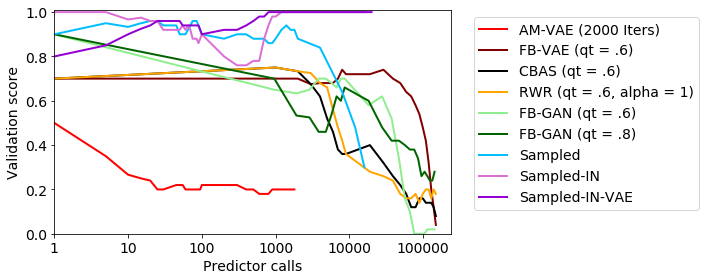

traj_names = ['AM-VAE (2000 Iters)', 'FB-VAE (qt = .6)', 'CBAS (qt = .6)', 'RWR (qt = .6, alpha = 1)', 'FB-GAN (qt = .6)', 'FB-GAN (qt = .8)', 'Sampled', 'Sampled-IN', 'Sampled-IN-VAE']
final_scores = [0.15, 0.0, 0.0, 0.1, 0.0, 0.15, 0.0, 1.0, 0.9]
rolling_final_scores = [0.15, 0.04, 0.07, 0.12, 0.01, 0.22, 0.28, 0.99, 0.85]


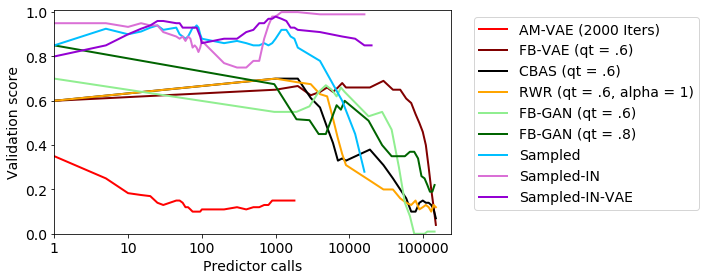

traj_names = ['AM-VAE (2000 Iters)', 'FB-VAE (qt = .6)', 'CBAS (qt = .6)', 'RWR (qt = .6, alpha = 1)', 'FB-GAN (qt = .6)', 'FB-GAN (qt = .8)', 'Sampled', 'Sampled-IN', 'Sampled-IN-VAE']
final_scores = [0.57, 0.5, 0.5, 0.5029, 0.5, 0.5243, 0.5, 0.9314, 0.86]
rolling_final_scores = [0.5737, 0.5097, 0.5094, 0.504, 0.5003, 0.5329, 0.5589, 0.9374, 0.8671]


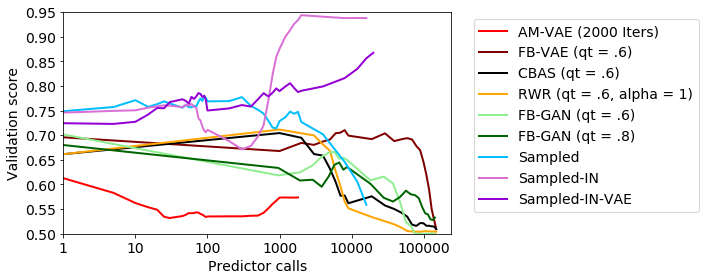

traj_names = ['AM-VAE (2000 Iters)', 'FB-VAE (qt = .6)', 'CBAS (qt = .6)', 'RWR (qt = .6, alpha = 1)', 'FB-GAN (qt = .6)', 'FB-GAN (qt = .8)', 'Sampled', 'Sampled-IN', 'Sampled-IN-VAE']
final_scores = [0.1, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.5, 0.8]
rolling_final_scores = [0.07, 0.03, 0.08, 0.0, 0.0, 0.32, 0.1, 0.52, 0.75]


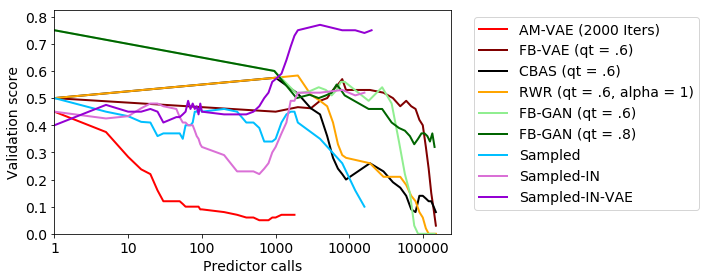

traj_names = ['AM-VAE (2000 Iters)', 'FB-VAE (qt = .6)', 'CBAS (qt = .6)', 'RWR (qt = .6, alpha = 1)', 'FB-GAN (qt = .6)', 'FB-GAN (qt = .8)', 'Sampled', 'Sampled-IN', 'Sampled-IN-VAE']
final_scores = [0.1712, 0.0303, 0.1941, 0.0131, 0.0081, 0.3222, 0.0597, 0.8736, 0.9073]
rolling_final_scores = [0.172, 0.1014, 0.207, 0.0141, 0.008, 0.3926, 0.3166, 0.8749, 0.8919]


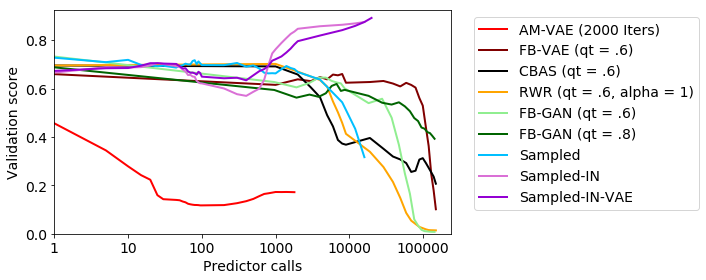

traj_names = ['AM-VAE (2000 Iters)', 'FB-VAE (qt = .6)', 'CBAS (qt = .6)', 'RWR (qt = .6, alpha = 1)', 'FB-GAN (qt = .6)', 'FB-GAN (qt = .8)', 'Sampled', 'Sampled-IN', 'Sampled-IN-VAE']
final_scores = [0.0824, 0.005, 0.07, 0.002, 0.0009, 0.1245, 0.0114, 0.5235, 0.5564]
rolling_final_scores = [0.0821, 0.0336, 0.0799, 0.0023, 0.0008, 0.1654, 0.1353, 0.5064, 0.544]


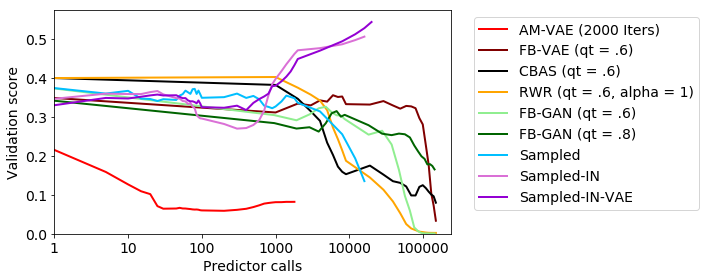

In [17]:
#Plot trajectory data

problem_prefix = "benchmark_mpradragonn_external_median_repeat"

experiment_suffix = "_traj_comparisons_log"

model_colors = ['red', 'maroon', 'black', 'orange', 'lightgreen', 'darkgreen', 'deepskyblue', 'orchid', 'darkviolet', 'indigo']

figsize = (10, 4)

save_figs = True

n_gt_predictors = 6

gt_predictor_min_y_vals = [
    [0.0, 0.0, 0.5, 0.0, 0.0, 0.0]
]

gt_predictor_max_y_vals = [
    [1.01, 1.01, 0.95, 0.825, 0.925, 0.575]
]

rolling_window = 5

for gt_predictor_ix in range(n_gt_predictors) :
    
    final_scores = [
        round([
            model_trajs[model_i][i, gt_predictor_ix]
            for i in range(model_iters[model_i].shape[0])
                if not np.isnan(model_trajs[model_i][i, gt_predictor_ix])
        ][-1], 4)
        for model_i in range(len(model_trajs))
    ]
    rolling_final_scores = [
        round([
            _rolling_average(model_trajs[model_i][:, gt_predictor_ix], window=rolling_window)[i]
            for i in range(model_iters[model_i].shape[0])
                if not np.isnan(model_trajs[model_i][i, gt_predictor_ix])
        ][-1], 4)
        for model_i in range(len(model_trajs))
    ]
    print("traj_names = " + str(traj_names))
    print("final_scores = " + str(final_scores))
    print("rolling_final_scores = " + str(rolling_final_scores))
    
    plot_trajectories(
        model_iters,
        model_trajs,
        traj_names,
        [None, None, None, None, None, None, None, None, None, None],
        gt_predictor_ix,
        'Predictor calls',
        'Validation score',
        rolling_window=rolling_window,
        colors=model_colors,
        min_x_val=0,
        max_x_val=None,
        min_y_val=gt_predictor_min_y_vals[0][gt_predictor_ix],
        max_y_val=gt_predictor_max_y_vals[0][gt_predictor_ix],
        figsize=figsize,
        save_fig=save_figs,
        fig_name=problem_prefix + experiment_suffix + "_validation_" + str(gt_predictor_ix) + "_log",
        legend_outside=True,
        log10_scale=True
    )
